# Notebook to construct and train a GNN on a corpus of British Folk/Traditional melodies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

print(torch.__version__)
print(torch.version.cuda)

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

2.1.0
None


### Load the data:

In [3]:
# Load the features data and edge-list:

with open('./Dataset/file_features_clean.pkl', 'rb') as f:
    # Load the serialized object from the file
    file_features = pickle.load(f)

with open('./Dataset/5_class_edge_df_50yrN.pkl', 'rb') as f:
    # Load the serialized object from the file
    edge_data = pickle.load(f)

with open('./Dataset/normalised_pitch_vectors_clean.pkl', 'rb') as f:
    # Load the serialized object from the file
    normalised_pitch_vectors = pickle.load(f)

with open('./Dataset/normalised_rhythm_vectors_clean.pkl', 'rb') as f:
    # Load the serialized object from the file
    normalised_rhythm_vectors = pickle.load(f)

In [4]:
edge_data

,node_1,node_2,cost
0,1795_Gretna Green. VWMLa.193.abc,"1825_Drunken Drummer. JBut.230, The.abc",30
1,1795_Gretna Green. VWMLa.193.abc,1756_Honest Miller. WCD3.abc,39
2,1795_Gretna Green. VWMLa.193.abc,1758_Jack's Delight THO1.190.abc,37
3,1795_Gretna Green. VWMLa.193.abc,"1837_Lass of Richmond Hill, The.abc",42
4,1795_Gretna Green. VWMLa.193.abc,1756_St. Brides. WCD3.abc,39
...,...,...,...
99995,1651_Once I Loved a Maiden Fair.abc,"1694_Gavott. HA.167, The.abc",43
99996,1651_Once I Loved a Maiden Fair.abc,1651_Broome:The bonny bonny Broome.abc,0
99997,1651_Once I Loved a Maiden Fair.abc,"1694_Flower Of Yarrow. HA.030, The.abc",43
99998,1651_Once I Loved a Maiden Fair.abc,1651_Greenwood.abc,0


### Convert the data into pyg data objects for feeding into the GNN:

Creating an edge_index (LongTensor), shape [2, num_edges].

Creating a node feature matrix (torch.Tensor) of shape [num_nodes, num_node_features].

Creating edge_attr feature matrix (torch.Tensor), shape [num_edges, num_edge_features].

In [279]:
# Delete any tunes with empty pitch and/or rhythm vectors:
print('...Cleaning node feature data by deleting tunes with empty features')
deleted_tunes = []
for tune, vectors in file_features.items():
    pitch_vector = vectors[0]
    rhythm_vector = vectors[1]

    if (len(pitch_vector) == 0) or (len(rhythm_vector) == 0):
        deleted_tunes.append((tune, vectors))

print('number of tunes to delete:', len(deleted_tunes))
for tune in deleted_tunes:
    del file_features[tune[0]]
deleted_tune_names = [tune[0] for tune in deleted_tunes]
edge_data = edge_data.loc[~(edge_data['node_1'].isin(deleted_tune_names) | edge_data['node_2'].isin(deleted_tune_names))]
print('...Finished cleaning node data')


# Convert edge_df to edge list (with indices):
unique_nodes = np.unique(edge_data[['node_1', 'node_2']].values)
node_to_index = {node: i for i, node in enumerate(unique_nodes)} # create a dict to map node names to indices
edge_data.loc[:, 'node_1'] = edge_data['node_1'].map(node_to_index)
edge_data.loc[:, 'node_2'] = edge_data['node_2'].map(node_to_index)
edge_index = edge_data[['node_1', 'node_2']].values.T  # Transpose to get two rows
edge_index = edge_index.astype(np.int64) # ensure correct type
edge_index = torch.from_numpy(edge_index).long()
print('...Finished creating edge_index')


# Find median pitch vector length:
pitch_vector_len = len(list(normalised_pitch_vectors.items())[0][1])
rhythm_vector_len = len(list(normalised_rhythm_vectors.items())[0][1])
print('Length of all pitch vectors:', pitch_vector_len)
print('Length of all rhythm vectors:', rhythm_vector_len)



# Combine pitch and rhythm vectors into one dict, with key as ind:
print('...Converting tune names to indices...')
file_features_inds = {}
exceptions = []
for tune_name, pitch_vector in normalised_pitch_vectors.items():
    try:
        index = node_to_index[tune_name]
        rhythm_vector = normalised_rhythm_vectors[tune_name]
        file_features_inds[index] = ((pitch_vector, rhythm_vector)) # add to new dict at specific ind
    except:
        pass # as not all nodes in the whole dataset are being used



# Create empty feature matrix:
print('...Creating node_feature_matrix...')
num_node_features = pitch_vector_len + rhythm_vector_len
node_feature_matrix = torch.empty((len(file_features_inds), num_node_features))


# Convert vectors to torch tensor and add to feature matrix:
for ind, features in file_features_inds.items():
    pitch_vector = features[0]
    pitch_vector= torch.tensor(pitch_vector)

    rhythm_vector = features[1]
    rhythm_vector= torch.tensor(rhythm_vector)

    node_features = torch.cat((pitch_vector, rhythm_vector))

    node_feature_matrix[ind, :] = node_features
print('...Finished creating node_feature_matrix:', node_feature_matrix)
 

# Create edge_attr (cost) matrix:
edge_attr = torch.tensor(edge_data['cost'].values)
edge_attr = edge_attr.view(len(edge_attr), 1)
print('...Finished creating edge_attr')


# Combining into one single Data object:
tune_data = Data(x=node_feature_matrix, edge_index=edge_index, edge_attr=edge_attr)
print('tune_data pyg Data object: ', tune_data)

print('Done')


...Cleaning node feature data by deleting tunes with empty features
number of tunes to delete: 0
...Finished cleaning node data
...Finished creating edge_index
Length of all pitch vectors: 13
Length of all rhythm vectors: 11
...Converting tune names to indices...
...Creating node_feature_matrix...
...Finished creating node_feature_matrix: tensor([[ 4.,  5., 12.,  ...,  9.,  0.,  0.],
        [ 5.,  3., 18.,  ...,  0.,  0.,  0.],
        [ 2., 25., 42.,  ..., 10.,  0.,  0.],
        ...,
        [31., 37., 91.,  ...,  5.,  0.,  0.],
        [ 6., 12., 21.,  ...,  1.,  0.,  0.],
        [16.,  6., 19.,  ...,  1.,  0.,  0.]])
...Finished creating edge_attr
tune_data pyg Data object:  Data(x=[1000, 24], edge_index=[2, 100000], edge_attr=[100000, 1])
Done


In [280]:
# Load target values and convert to indices:
tune_year_labels_path = 'Data/5_class_tune_year_labels.pkl'
with open(tune_year_labels_path, 'rb') as f:
    tune_year_labels = pickle.load(f)

tune_year_labels.loc[:, 'tune'] = tune_year_labels['tune'].map(node_to_index)
tune_year_labels = tune_year_labels.dropna()
nan_rows = tune_year_labels[tune_year_labels['tune'].isna()]

tune_year_labels = tune_year_labels.astype(np.int64) # ensure correct type


# Ensure correct labels for each index:
index_to_node = {v: k for k, v in node_to_index.items()}
for i in range(10):
    random_int = random.randint(0, 300)
    tune_ind = int(tune_year_labels.loc[random_int]['tune'])
    tune_year = int(tune_year_labels.loc[random_int]['year'])
    tune = index_to_node[tune_ind]
    tune_year_check = int(tune[:4])

    print(tune_year, tune_year_check)
    if np.abs(tune_year_check - tune_year) >= 50:
        print('uh oh!')


# Drop index col and map labels to numbers:
tune_year_values = tune_year_labels['year'].values

if tune_year_labels_path.startswith('Data/4'):
    label_mapping = {1700: 0, 1750: 1, 1800: 2, 1850: 3}
    print('Mapping to 4 classes')
elif tune_year_labels_path.startswith('Data/5'):
    label_mapping = {1650: 0, 1700: 1, 1750: 2, 1800: 3, 1850: 4}
    print('Mapping to 5 classes')
elif tune_year_labels_path.startswith('Data/10'):
    label_mapping = {1650: 0, 1675: 1, 1700: 2, 1725: 3, 1750: 4, 1775: 5, 1800: 6, 1825: 7, 1850: 8, 1875: 9}
    print('Mapping to 10 classes')
else:
    print('Error, number of classes does not match a mapping')

map_func = np.vectorize(label_mapping.get)
tune_year_values = map_func(tune_year_values)


# Convert to torch tensor
tune_year_values = torch.from_numpy(tune_year_values).long()
print('number of labels: ', tune_year_values.shape[0])


# Add to tune_data Data object:
tune_data.y = tune_year_values
print('tune_data: ', tune_data)

1700 1721
1850 1860
1750 1754
1800 1825
1800 1801
1700 1748
1750 1799
1800 1810
1700 1748
1750 1758
Mapping to 5 classes
number of labels:  1000
tune_data:  Data(x=[1000, 24], edge_index=[2, 100000], edge_attr=[100000, 1], y=[1000])


In [281]:
count = 0
for i, year in enumerate(tune_year_values):
    year = year.item()
    if year == 0:
        count+=1

print(count)

200


In [282]:
tune_data

Data(x=[1000, 24], edge_index=[2, 100000], edge_attr=[100000, 1], y=[1000])

In [283]:
# Number of nodes per train, val, test split:
num_nodes = tune_data.x.shape[0]
num_train_nodes = int(np.floor(num_nodes * 0.7))
num_val_nodes = (num_nodes - num_train_nodes) // 2
num_test_nodes = num_nodes - (num_train_nodes + num_val_nodes)

# Define split:
split = T.RandomNodeSplit('train_rest', num_val=num_val_nodes, num_test=num_test_nodes)

# Apply split:
tune_data = split(tune_data)

# Count the number of nodes in each split
train_count = tune_data.train_mask.sum().item()
val_count = tune_data.val_mask.sum().item()
test_count = tune_data.test_mask.sum().item()

# Print the counts and shapes to ensure correctness:
print('Train mask shape: ', tune_data.train_mask.shape)
print(f"Number of training nodes: {train_count} (expected: {num_train_nodes})")
print('Val mask shape: ', tune_data.val_mask.shape)
print(f"Number of validation nodes: {val_count} (expected: {num_val_nodes})")
print('Test mask shape: ', tune_data.test_mask.shape)
print(f"Number of test nodes: {test_count} (expected: {num_test_nodes})")

Train mask shape:  torch.Size([1000])
Number of training nodes: 700 (expected: 700)
Val mask shape:  torch.Size([1000])
Number of validation nodes: 150 (expected: 150)
Test mask shape:  torch.Size([1000])
Number of test nodes: 150 (expected: 150)


In [284]:
# Get the class labels of validation nodes
val_labels = tune_data.y[tune_data.val_mask]

# Count the number of instances of each class label in the validation set
unique_classes, class_counts = torch.unique(val_labels, return_counts=True)

# Print the counts of each class in the validation set
for cls, count in zip(unique_classes.tolist(), class_counts.tolist()):
    print(f"Class {cls}: {count} nodes in validation set")

Class 0: 35 nodes in validation set
Class 1: 27 nodes in validation set
Class 2: 29 nodes in validation set
Class 3: 34 nodes in validation set
Class 4: 25 nodes in validation set


In [286]:
# # Save data-split for testing:
# saved_split_data_path = 'split_data/' + '5_class_50yrN_split' + '.pkl'
# with open(saved_split_data_path, 'wb') as handle:
#     pickle.dump(tune_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load data from file::

In [2]:
data_path = 'split_data/10_class_50yrN_split.pkl'
with open(data_path, 'rb') as f:
    # Load the serialized object from the file
    tune_data = pickle.load(f)

In [312]:
# Get the class labels of test nodes
test_labels = tune_data.y[tune_data.test_mask]

# Count the number of instances of each class label in the test set
unique_classes, class_counts = torch.unique(test_labels, return_counts=True)

# Print the counts of each class in the test set
for cls, count in zip(unique_classes.tolist(), class_counts.tolist()):
    print(f"Class {cls}: {count} nodes in test set")

Class 0: 14 nodes in test set
Class 1: 20 nodes in test set
Class 2: 13 nodes in test set
Class 3: 18 nodes in test set
Class 4: 11 nodes in test set
Class 5: 16 nodes in test set
Class 6: 14 nodes in test set
Class 7: 19 nodes in test set
Class 8: 13 nodes in test set
Class 9: 12 nodes in test set


In [313]:
# Get the class labels of val nodes
val_labels = tune_data.y[tune_data.val_mask]

# Count the number of instances of each class label in the val set
unique_classes, class_counts = torch.unique(val_labels, return_counts=True)

# Print the counts of each class in the val set
for cls, count in zip(unique_classes.tolist(), class_counts.tolist()):
    print(f"Class {cls}: {count} nodes in val set")

Class 0: 16 nodes in val set
Class 1: 17 nodes in val set
Class 2: 15 nodes in val set
Class 3: 11 nodes in val set
Class 4: 14 nodes in val set
Class 5: 15 nodes in val set
Class 6: 11 nodes in val set
Class 7: 19 nodes in val set
Class 8: 12 nodes in val set
Class 9: 20 nodes in val set


### Define Model:

Based on implementation in: https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing

In [314]:
class GCN_Classifier(torch.nn.Module):
    '''GCN_Classifier Model'''

    # Define layers:
    def __init__(self, dim_in, dim_h, num_classes):
        super().__init__()
        self.conv1 = GCNConv(dim_in, dim_h, cached=True)
        self.conv2 = GCNConv(dim_h, num_classes, cached=True)

    # Define forward function:
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.1, training=self.training)
        h = self.conv2(h, edge_index)

        return h 

### Train and test functions:

In [315]:
def train_model(model, data, optimiser, criterion, n_epochs, saved_model_path, print_metrics=True, save_best_model=False):
    ''' 
    Function to train a GCN Classification model.

    Inputs:
    - model (torch.nn.Module): GCN Classification model
    - data (pytorch_geometric.loader.NeighborLoader)
    - optmiser (torch.optim)
    - criterion (torch.nn): Loss function
    - n_epochs (int): Number of epochs to train for
    - saved_model_path (str): Path to save the best model to
    - print_metrics (bool): Whether to print metrics whilst training
    - save_best_model (bool): Whether to save the best model during training

    Returns:
    - train_loss (float): Training loss
    - val_loss (float): Validation loss
    - peak_val_acc (float): Peak validation accuracy
    
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training loop:

    peak_val_acc = 0.0
    train_loss_lst = []    
    val_loss_lst = []
    epoch_lst = []


    for epoch in range(n_epochs+1):

        model.train()
        optimiser.zero_grad()

        # Forward pass:
        data = data.to(device)
        out = model(data.x, data.edge_index)

        # Calc. loss:
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        train_loss = loss.item()
        loss.backward()
        optimiser.step()



        # Calculate train accuracy
        pred = out.argmax(dim=1)
        train_correct = (pred[data.train_mask] == data.y[data.train_mask]).sum().item()
        train_total = data.train_mask.sum().item()
        train_accuracy = train_correct / train_total
        
        num_train_nodes = data.train_mask.sum().item()
        train_accuracy = train_correct / train_total
        

        # Validation:
        if epoch % 5 == 0:

            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                model.eval()
                out = model(data.x, data.edge_index)
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

                # Calculate validation accuracy
                pred = out.argmax(dim=1)
                val_correct = (pred[data.val_mask] == data.y[data.val_mask]).sum().item()
                val_total = data.val_mask.sum().item()
                val_accuracy = val_correct / val_total

                # Add train and val loss to lst
                train_loss_lst.append(train_accuracy)
                val_loss_lst.append(val_accuracy)
                epoch_lst.append(epoch)

                if val_accuracy > peak_val_acc:
                    peak_val_acc = val_accuracy

                    # Save best model:
                    if save_best_model:
                        torch.save(model.state_dict(), saved_model_path)
                        print("Model saved")
            
            if print_metrics:
                print('Epoch: ', epoch)
                print('Train loss: ', train_loss)
                print('Train accuracy: ', train_accuracy)
                print('Val loss: ', val_loss)
                print('Val accuracy: ', val_accuracy)

    # Plot losses:
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_lst, train_loss_lst, label='Training Accuracy')
    plt.plot(epoch_lst, val_loss_lst, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy of GCN Model')
    plt.grid(True)
    plt.legend()
    plt.show()


    return train_loss, val_loss, peak_val_acc

In [316]:
def test_model(model, data, num_classes, print_metrics=True):
    ''' 
    Function to test GNN and plot a confusion matrix

    Inputs:
    - model (torch.NN.Module): GNN model
    - data: Pytorch Geometric Data object
    - print_metrics (bool): Whether or not to print accuracy and confusion matrix

    Returns:
    - test_accuracy (float): Test accuracy of the model

    '''
    with torch.no_grad():
        model.eval()
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
        test_total = data.test_mask.sum().item()
        test_accuracy = test_correct / test_total
    
    if print_metrics:
        print('Test accuracy:', test_accuracy)

        # Convert prediction and label tensors to numpy arrays
        preds = pred[data.test_mask].cpu().numpy()
        labels = data.y[data.test_mask].cpu().numpy()

        # Build confusion matrix:
        if num_classes == 4:
            classes = ('1700', '1750', '1800', '1850')
        if num_classes == 5:
            classes = ('1650', '1700', '1750', '1800', '1850') 
        if num_classes == 10:
            classes = ('1650', '1675', '1700', '1725', '1750', '1775', '1800',  '1825', '1850', '1875')
        cf_matrix = confusion_matrix(labels, preds) # build confusion matrix
        cf_matrix_df = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes]) # normalise, convert to cols, store in dataframe 
        plt.figure(figsize = (12,7))
        plt.title('Folk-Song Dating Confusion Matrix')
        sn.heatmap(cf_matrix_df, annot=True)
    
    return test_accuracy

### Grid search:

In [ ]:
### Perform grid-search to find optimum number of out_channels:

dim_h_grid = [8, 16, 32, 64, 128]
lr_grid = [0.001, 0.01]
num_classes = 10
saved_model_path = 'Ignore'

results_dict = {}

for dim_h in dim_h_grid:
    for lr in lr_grid:
        print('Training: ', dim_h, ' hidden dims', 'with lr: ', lr)

        peak_val_acc = 0.0
        
        dim_in = tune_data.num_features
        epochs = 500

        
        # Train:
        model = GCN_Classifier(dim_in, dim_h, num_classes)

        optimiser = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        _, _, peak_val_acc = train_model(model, tune_data, optimiser, criterion, epochs, saved_model_path, False, False)

        results_dict[(dim_h, lr)] = peak_val_acc
        
        print('Finished training: ', dim_h, ' hidden dims,', lr, ' lr', ', achieved peak_val_acc: ', peak_val_acc)      


### Final Training:

In [329]:
# Parameters
dim_in = tune_data.num_features
dim_h = 128
num_classes = 10
saved_model_path = 'run5_GNN_best_model_10Classes_50yrN.pth'

# model
model = GCN_Classifier(dim_in, dim_h, num_classes)

# Optimiser and loss criterion:
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Model saved
Epoch:  0
Train loss:  15.989588737487793
Train accuracy:  0.10714285714285714
Val loss:  6.722299098968506
Val accuracy:  0.12666666666666668
Model saved
Epoch:  5
Train loss:  9.913862228393555
Train accuracy:  0.1
Val loss:  8.294416427612305
Val accuracy:  0.17333333333333334
Epoch:  10
Train loss:  7.286895275115967
Train accuracy:  0.15428571428571428
Val loss:  6.2045769691467285
Val accuracy:  0.17333333333333334
Epoch:  15
Train loss:  4.860747814178467
Train accuracy:  0.15285714285714286
Val loss:  4.116943836212158
Val accuracy:  0.14
Model saved
Epoch:  20
Train loss:  2.6084020137786865
Train accuracy:  0.16428571428571428
Val loss:  2.3059816360473633
Val accuracy:  0.20666666666666667
Model saved
Epoch:  25
Train loss:  2.845956325531006
Train accuracy:  0.16285714285714287
Val loss:  2.609222412109375
Val accuracy:  0.23333333333333334
Model saved
Epoch:  30
Train loss:  2.028597831726074
Train accuracy:  0.26
Val loss:  2.0111420154571533
Val accuracy:  0.

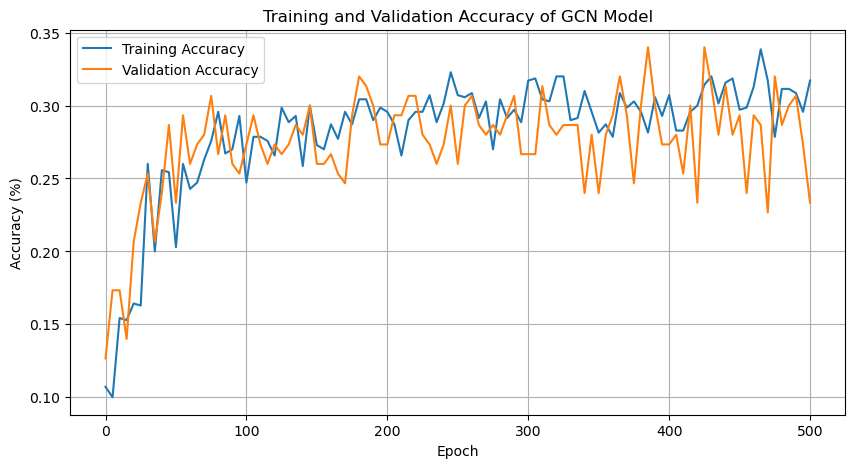

Peak val acc:  0.34


In [330]:
train_loss, val_loss, peak_val_acc = train_model(model, tune_data, optimiser, criterion, 500, saved_model_path, True, True)
print('Peak val acc: ', peak_val_acc)

Test accuracy: 0.26666666666666666


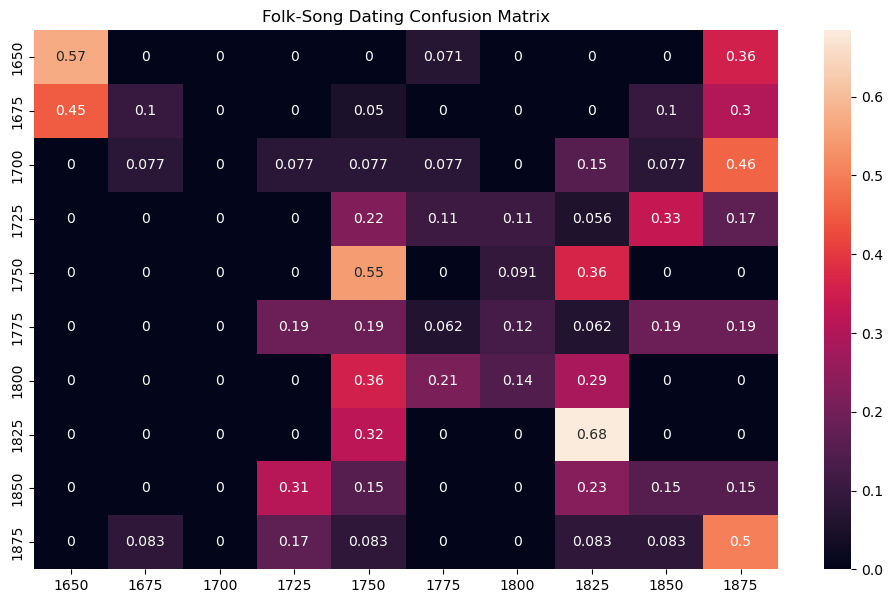

In [331]:
model_path = saved_model_path

dim_in = tune_data.num_features
dim_h = 128
num_classes = 10
model = GCN_Classifier(dim_in, dim_h, num_classes)

model.load_state_dict(torch.load(model_path))

test_accuracy = test_model(model, tune_data, num_classes)

In [81]:
# with open('run1_5Class_25YrN_tunedata.pkl', 'wb') as handle:
#     pickle.dump(tune_data, handle, protocol=pickle.HIGHEST_PROTOCOL)